In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler

In [35]:
file_path = 'archive/shot_logs.csv'
data = pd.read_csv(file_path)
print(data.head(3))

    GAME_ID                   MATCHUP LOCATION  W  FINAL_MARGIN  SHOT_NUMBER  \
0  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            1   
1  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            2   
2  21400899  MAR 04, 2015 - CHA @ BKN        A  W            24            3   

   PERIOD GAME_CLOCK  SHOT_CLOCK  DRIBBLES  ...  SHOT_DIST  PTS_TYPE  \
0       1       1:09        10.8         2  ...        7.7         2   
1       1       0:14         3.4         0  ...       28.2         3   
2       1       0:00         NaN         3  ...       10.1         2   

   SHOT_RESULT   CLOSEST_DEFENDER CLOSEST_DEFENDER_PLAYER_ID  CLOSE_DEF_DIST  \
0         made     Anderson, Alan                     101187             1.3   
1       missed  Bogdanovic, Bojan                     202711             6.1   
2       missed  Bogdanovic, Bojan                     202711             0.9   

   FGM  PTS    player_name player_id  
0    1    2  brian roberts    

In [36]:
constant_columns = [col for col in data.columns if data[col].nunique() == 1]
monotonous_columns = [
    col for col in data.columns
    if data[col].is_monotonic_increasing or data[col].is_monotonic_decreasing
]
columns_to_remove = list(set(constant_columns + monotonous_columns))
data_cleaned = data.drop(columns=columns_to_remove)
print(columns_to_remove)
data = data_cleaned

[]


In [37]:
missing_values = data.isnull().sum()
print("Broj redova: ",len(data))
print("Broj nedostajucih vrijednosti: \n",missing_values)
#Zamjena se radi kada je stupac bitan za analizu i ima malo nedostajucih zapisa
#Uklanjanje se radi kada stupac nije bitan za analizu ili ima previse nedostajucih zapisa
rowNumToDrop = 0.5 * len(data)
columns_to_drop = [col for col in data.columns if data[col].isnull().sum() > rowNumToDrop]
print("---> Stupce koje treba ukloniti: ",columns_to_drop) #Nema dovoljno nedostajucih vrijednosti za uklanjanje stupca
data = data.drop(columns=columns_to_drop)

num_columns = data.select_dtypes(include=['float64', 'int64']).columns
for col in num_columns:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].median())
        print("Zamjenjene vrijednosti ",col," sa srednjom vrijednosti.")

cat_columns = data.select_dtypes(include=['object']).columns
for col in cat_columns:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].mode()[0])
        print("Zamjenjene vrijednosti ",col," sa najcescom vrijednoscu")

print("---> Broj nedostajucih vrijednosti ",data.isnull().sum().sum())

Broj redova:  128069
Broj nedostajucih vrijednosti: 
 GAME_ID                          0
MATCHUP                          0
LOCATION                         0
W                                0
FINAL_MARGIN                     0
SHOT_NUMBER                      0
PERIOD                           0
GAME_CLOCK                       0
SHOT_CLOCK                    5567
DRIBBLES                         0
TOUCH_TIME                       0
SHOT_DIST                        0
PTS_TYPE                         0
SHOT_RESULT                      0
CLOSEST_DEFENDER                 0
CLOSEST_DEFENDER_PLAYER_ID       0
CLOSE_DEF_DIST                   0
FGM                              0
PTS                              0
player_name                      0
player_id                        0
dtype: int64
---> Stupce koje treba ukloniti:  []
Zamjenjene vrijednosti  SHOT_CLOCK  sa srednjom vrijednosti.
---> Broj nedostajucih vrijednosti  0


In [38]:
def convert_to_seconds(clock):
    minutes, seconds = map(int, clock.split(':'))
    return minutes * 60 + seconds

data['GAME_CLOCK'] = data['GAME_CLOCK'].apply(convert_to_seconds)

print(data[['GAME_CLOCK']].head(10))

   GAME_CLOCK
0          69
1          14
2           0
3         707
4         634
5         495
6         615
7         480
8         314
9         692


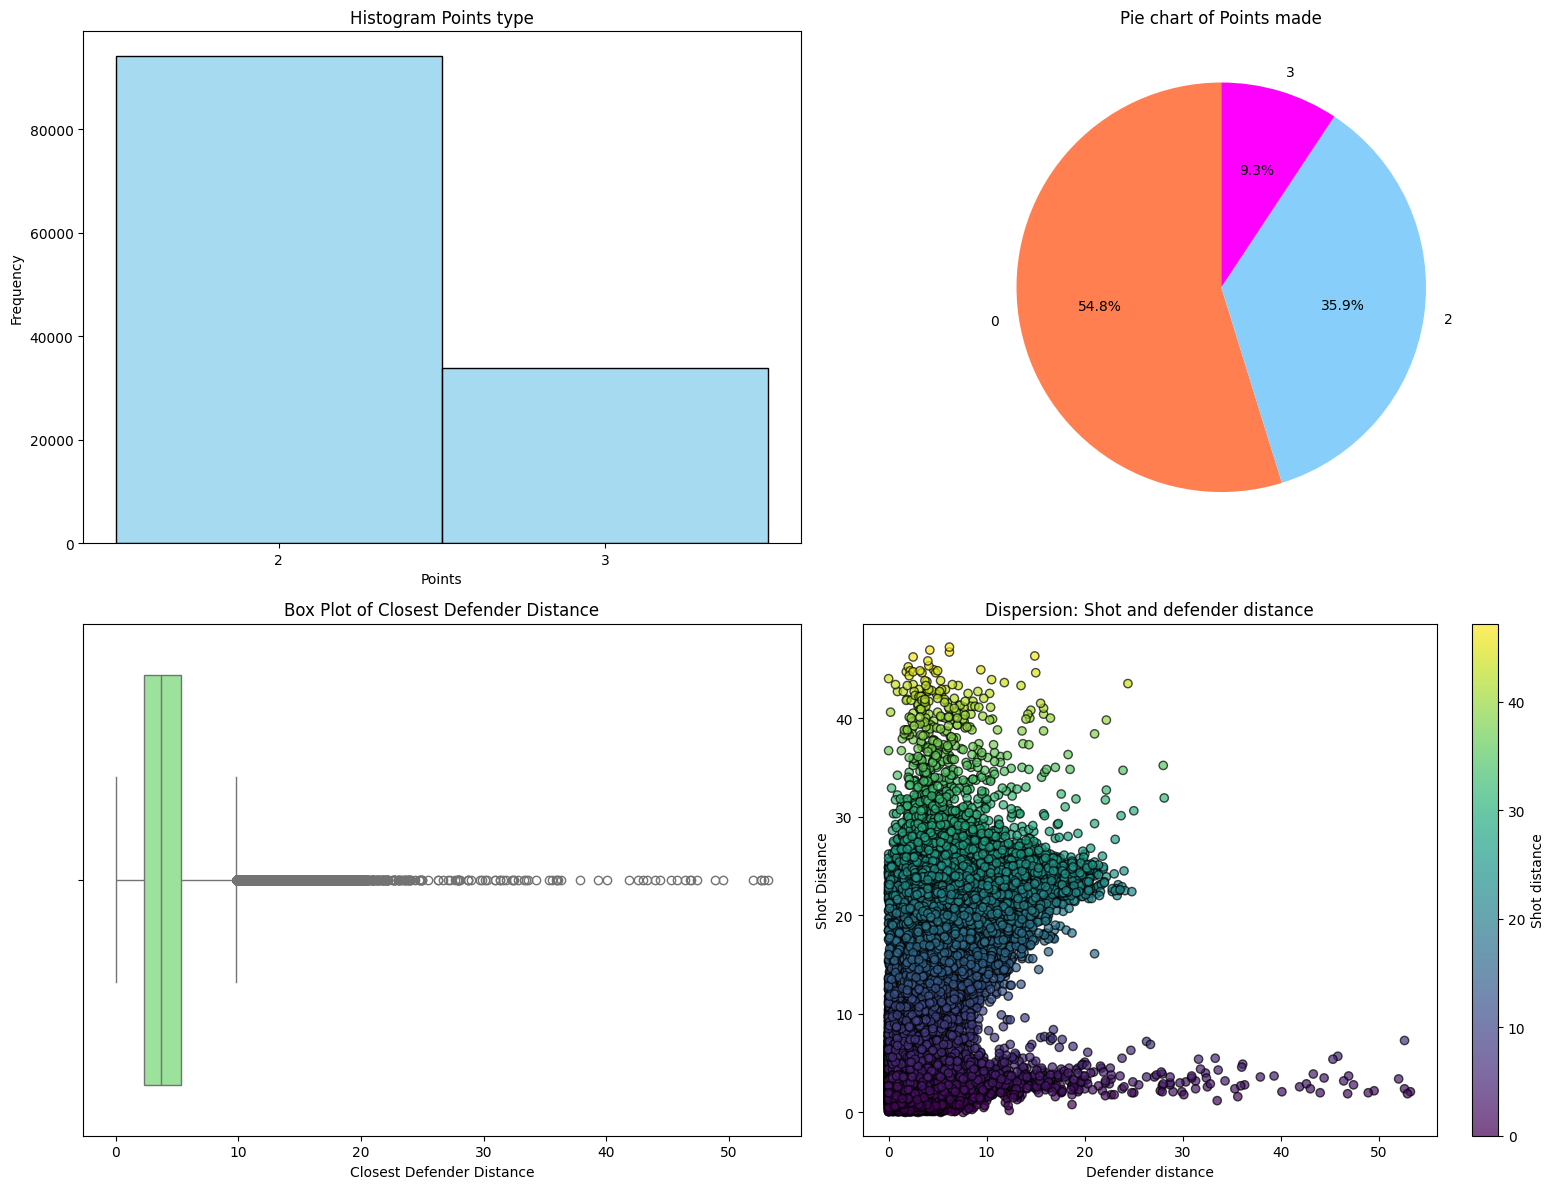

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(data['PTS_TYPE'], ax=axes[0, 0], kde=False, color='skyblue',discrete=True)
axes[0, 0].set_title('Histogram Points type')
axes[0, 0].set_xlabel('Points')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xticks([2, 3])

status_counts = data['PTS'].value_counts()
axes[0, 1].pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=['coral', 'lightskyblue','magenta'])
axes[0, 1].set_title('Pie chart of Points made')

sns.boxplot(data=data, x='CLOSE_DEF_DIST', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Box Plot of Closest Defender Distance')
axes[1, 0].set_xlabel('Closest Defender Distance')

scatter = axes[1, 1].scatter(
    data['CLOSE_DEF_DIST'], 
    data['SHOT_DIST'], 
    c=data['SHOT_DIST'], 
    cmap='viridis', 
    edgecolor='k', 
    alpha=0.7
)
axes[1, 1].set_title('Dispersion: Shot and defender distance')
axes[1, 1].set_xlabel('Defender distance')
axes[1, 1].set_ylabel('Shot Distance')
cbar = fig.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('Shot distance')

plt.tight_layout()
plt.show()